In [1]:
import torch
import pandas as pd
import numpy as np
import cv2
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from transformers import ViTForImageClassification
from google.colab import drive
import os
from sklearn.model_selection import train_test_split
import wandb

In [2]:
drive.mount('/content/drive')
image_folder = '/content/drive/MyDrive/Курсовая/images/'
metadata_path = '/content/drive/MyDrive/Курсовая/HAM10000_metadata.tab'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df = pd.read_csv(metadata_path, sep='\t', header=None)
df.columns = ['lesion_id', 'image_id', 'diagnosis', 'type_of_diagnostic', 'age', 'sex', 'localization', 'source']
df['image_path'] = df['image_id'].apply(lambda x: os.path.join(image_folder, x + '.jpg'))
df.head()

,lesion_id,image_id,diagnosis,type_of_diagnostic,age,sex,localization,source,image_path
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,/content/drive/MyDrive/Курсовая/images/ISIC_00...
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,/content/drive/MyDrive/Курсовая/images/ISIC_00...
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,/content/drive/MyDrive/Курсовая/images/ISIC_00...
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,/content/drive/MyDrive/Курсовая/images/ISIC_00...
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,/content/drive/MyDrive/Курсовая/images/ISIC_00...


In [4]:
benign_diagnoses = ['bkl', 'nv', 'df', 'vasc']  # доброкачественные будут 1, злокачественные 0
df['label'] = df['diagnosis'].apply(lambda x: 0 if x in benign_diagnoses else 1)
df.head()

,lesion_id,image_id,diagnosis,type_of_diagnostic,age,sex,localization,source,image_path,label
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,/content/drive/MyDrive/Курсовая/images/ISIC_00...,0
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,/content/drive/MyDrive/Курсовая/images/ISIC_00...,0
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,/content/drive/MyDrive/Курсовая/images/ISIC_00...,0
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,/content/drive/MyDrive/Курсовая/images/ISIC_00...,0
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,/content/drive/MyDrive/Курсовая/images/ISIC_00...,0


In [5]:
df.drop(columns=['diagnosis'], inplace=True)
df.head()

,lesion_id,image_id,type_of_diagnostic,age,sex,localization,source,image_path,label
0,HAM_0000118,ISIC_0027419,histo,80.0,male,scalp,vidir_modern,/content/drive/MyDrive/Курсовая/images/ISIC_00...,0
1,HAM_0000118,ISIC_0025030,histo,80.0,male,scalp,vidir_modern,/content/drive/MyDrive/Курсовая/images/ISIC_00...,0
2,HAM_0002730,ISIC_0026769,histo,80.0,male,scalp,vidir_modern,/content/drive/MyDrive/Курсовая/images/ISIC_00...,0
3,HAM_0002730,ISIC_0025661,histo,80.0,male,scalp,vidir_modern,/content/drive/MyDrive/Курсовая/images/ISIC_00...,0
4,HAM_0001466,ISIC_0031633,histo,75.0,male,ear,vidir_modern,/content/drive/MyDrive/Курсовая/images/ISIC_00...,0


In [6]:
train_df, tmp_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(tmp_df, test_size=0.5, stratify=tmp_df['label'], random_state=42)

In [7]:
wandb.init(project="skin_lesion_classification", config={
    "learning_rate": 0.0001,
    "epochs": 100,
    "batch_size": 32,
    "architecture": "ViT",
    "dataset": "HAM10000"})

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: kalinicheva2007 (pdftotex) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [8]:
config = wandb.config

class SkinLesionDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['image_path']
        label = self.dataframe.iloc[idx]['label']
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = SkinLesionDataset(train_df, transform=transform)
val_dataset = SkinLesionDataset(val_df, transform=transform)
test_dataset = SkinLesionDataset(test_df, transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
model_name = 'google/vit-base-patch16-224-in21k'
model = ViTForImageClassification.from_pretrained(model_name, num_labels=2).to(device)  # бинарная

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)

In [12]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0, verbose=False, save_path='best_model.pth'):
        self.patience = patience
        self.delta = delta
        self.verbose = verbose
        self.save_path = save_path
        self.best_loss = float('inf')
        self.counter = 0
        self.early_stop = False

    def __call__(self, model, val_loss):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(model)
        else:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter}/{self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        return self.early_stop

    def save_checkpoint(self, model):
        torch.save(model.state_dict(), self.save_path)
        if self.verbose:
            print(f'Сохранены новые лучшие веса модели в: {self.save_path}')

    def load_best_model(self, model):
        model.load_state_dict(torch.load(self.save_path))
        if self.verbose:
            print(f'Загружены лучшие веса модели из: {self.save_path}')

In [13]:
def evaluate(model, dataloader):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            total_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    avg_loss = total_loss / total
    accuracy = 100 * correct / total
    return avg_loss, accuracy

In [14]:
def train_model(num_epochs):
    early_stopping = EarlyStopping(patience=5, verbose=True, save_path='best_model.pth')
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for batch_idx, (images, labels) in enumerate(train_dataloader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if batch_idx % 10 == 0:
                print(f'Epoch {epoch+1}, Batch {batch_idx}/{len(train_dataloader)}, Train Loss (batch): {running_loss/(batch_idx+1):.4f}')
        train_loss = running_loss / total
        train_accuracy = 100 * correct / total

        val_loss, val_accuracy = evaluate(model, val_dataloader)

        wandb.log({
            'epoch': epoch+1,
            'train_loss': train_loss,
            'train_accuracy': train_accuracy,
            'val_loss': val_loss,
            'val_accuracy': val_accuracy})

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

        if early_stopping(model, val_loss):
            print('Early stopping triggered...')
            break

    early_stopping.load_best_model(model)

In [15]:
train_model(num_epochs=config.epochs)

Epoch 1, Batch 0/220, Train Loss (batch): 23.8200
Epoch 1, Batch 10/220, Train Loss (batch): 14.8905
Epoch 1, Batch 20/220, Train Loss (batch): 13.4958
Epoch 1, Batch 30/220, Train Loss (batch): 13.1522
Epoch 1, Batch 40/220, Train Loss (batch): 12.7954
Epoch 1, Batch 50/220, Train Loss (batch): 12.5427
Epoch 1, Batch 60/220, Train Loss (batch): 12.2655
Epoch 1, Batch 70/220, Train Loss (batch): 12.1422
Epoch 1, Batch 80/220, Train Loss (batch): 11.8272
Epoch 1, Batch 90/220, Train Loss (batch): 11.5645
Epoch 1, Batch 100/220, Train Loss (batch): 11.4684
Epoch 1, Batch 110/220, Train Loss (batch): 11.3539
Epoch 1, Batch 120/220, Train Loss (batch): 11.1919
Epoch 1, Batch 130/220, Train Loss (batch): 11.0361
Epoch 1, Batch 140/220, Train Loss (batch): 10.9746
Epoch 1, Batch 150/220, Train Loss (batch): 10.9989
Epoch 1, Batch 160/220, Train Loss (batch): 10.8926
Epoch 1, Batch 170/220, Train Loss (batch): 10.7678
Epoch 1, Batch 180/220, Train Loss (batch): 10.6695
Epoch 1, Batch 190/220,

In [ ]:
model.load_state_dict(torch.load('/content/best_model.pth'))
model.to(device)

In [16]:
def evaluate_model():
    test_loss, test_accuracy = evaluate(model, test_dataloader)
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

evaluate_model()

Test Loss: 0.2919, Test Accuracy: 88.69%


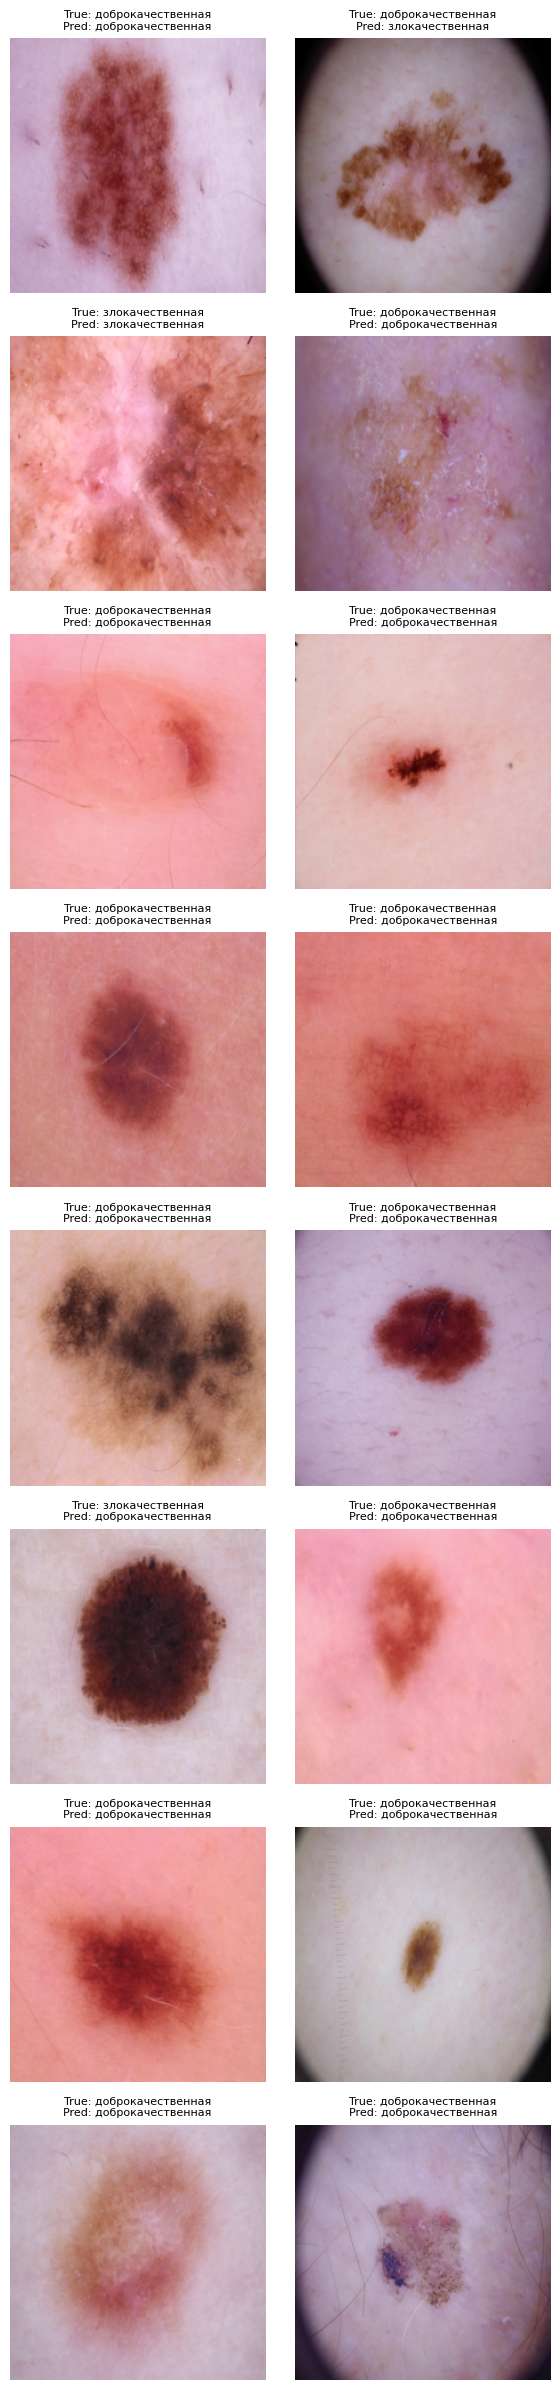

In [18]:
import matplotlib.pyplot as plt

def visualize_predictions(model, dataloader, grid_shape=(8, 2)):
    model.eval()
    n_rows, n_cols = grid_shape
    total_images = n_rows * n_cols
    label_map = {0: 'доброкачественная', 1: 'злокачественная'}

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3))
    # Преобразуем axes в одномерный массив для удобного перебора
    if isinstance(axes, (list, np.ndarray)):
        axes = axes.flatten()
    else:
        axes = [axes]

    images_shown = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images).logits
            _, preds = torch.max(outputs, 1)
            images = images.cpu()
            for i in range(images.shape[0]):
                if images_shown >= total_images:
                    break
                img = images[i].permute(1, 2, 0)
                img = img * 0.5 + 0.5
                ax = axes[images_shown]
                ax.imshow(img.numpy())
                true_label = label_map[labels[i].item()]
                pred_label = label_map[preds[i].item()]
                ax.set_title(f"True: {true_label}\nPred: {pred_label}", fontsize=8)
                ax.axis('off')
                images_shown += 1
            if images_shown >= total_images:
                break
    plt.tight_layout()
    plt.show()

visualize_predictions(model, test_dataloader, grid_shape=(8, 2))